In [1]:
import datetime
import glob
import os
import time
import unicodedata

import emoji
import nltk
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
from nltk.stem import Cistem
#from nltk.stem.snowball import GermanStemmer
from nltk.tokenize import TweetTokenizer

# Workaround for Jupyter's "This event loop is already running" exception
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import regex as re
import seaborn as sns
from wordcloud import WordCloud
import tweepy
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import QuantileTransformer

import twint

pd.options.mode.chained_assignment = None  # default='warn'


# Class Miner

In [2]:
class Miner(object):
    """A class providing the tools needed for downloading and preparing a new dataset for this project.

        It needs access to Twitter's API (see the class's twitter_keys property) via Tweepy for certain functions like
        getting the amount of followers of a given user but uses Twint for downloading tweets since Twitter's
        restrictions on their API would lead to extremely long waiting times.
    """
    result_limit = 100
    data         = []
    api          = False
    seed         = 42
    handle       = 'jack'
    lang         = 'de'

    twitter_keys = {
        'consumer_key':        'YOUR_CONSUMER_KEY_HERE',
        'consumer_secret':     'YOUR_CONSUMER_SECRET_HERE',
        'access_token':        'YOUR_ACCESS_TOKEN_HERE',
        'access_token_secret': 'YOUR_ACCESS_TOKEN_SECRET_HERE'
    }

    def __init__(self, keys_dict=twitter_keys, api=api, result_limit=20, handle=handle, lang=lang):
        """
        Initializes a new Miner instance.

        :param keys_dict: Dictionary containing Twitter API access details needed for Tweepy.
        :param api: TODO
        :param result_limit: TODO
        :param handle: The root handle of the dataset to be created.
        :param lang: The tweets' language used in the observed bubble. Every tweet in another language is dropped later on.
        """
        self.twitter_keys = keys_dict
        
        auth = tweepy.OAuthHandler(keys_dict['consumer_key'], keys_dict['consumer_secret'])
        auth.set_access_token(keys_dict['access_token'], keys_dict['access_token_secret'])
        
        self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        self.twitter_keys = keys_dict
        
        self.result_limit = result_limit
        self.handle = handle
        self.lang = lang
    
    def openIds(self):
        return pd.read_csv("{}/{}_ids.csv".format(self.handle, self.handle), encoding='utf-8')
    
    def openFollowers(self):
        return pd.read_csv("{}/{}_follower_ids.csv".format(self.handle, self.handle), encoding='utf-8')
    
    def openFollowing(self):
        return pd.read_csv("{}/{}_following_ids.csv".format(self.handle, self.handle), encoding='utf-8')
    
    def openFriends(self):
        return pd.read_csv("{}/{}_friends_ids.csv".format(self.handle, self.handle), encoding='utf-8')

    def openCSVs(self):
        """Opens and returns all downloaded tweets as a pandas dataframe."""
        files = glob.glob("{}/tweets/*.csv".format(self.handle))
        print("Opening {} CSV files.".format(len(files)))
        return pd.concat([pd.read_csv(f, encoding='utf-8') for f in files])
        
    
    def get_user_id(self, screen_name='jack'):
        """Gets and returns a given Twitter user's ID via Tweepy."""
        return self.api.get_user(screen_name=screen_name).id
    
    def get_user_by_id(self, userid=0):
        """Gets and returns a given Twitter user by the provided ID via Tweepy."""
        return self.api.get_user(id=userid)
    
    def get_relationships(self, user="jack"):
        """Gets, stores and returns the relationships of the given Twitter user.

            This method retrieves the given user's follower and following lists as well as their intersection ("friends").

            These lists are stored as CSV files.
        """
        follower_ids  = self.api.followers_ids(screen_name=user)
        following_ids = self.api.friends_ids(screen_name=user)
        friends_ids   = list(set(follower_ids).intersection(set(following_ids)))
        
        df = pd.DataFrame(follower_ids)
        df.to_csv('{}/{}_follower_ids.csv'.format(user, user), encoding='utf-8', line_terminator='\r\n', index=False)
        df = pd.DataFrame(following_ids)
        df.to_csv('{}/{}_following_ids.csv'.format(user, user), encoding='utf-8', line_terminator='\r\n', index=False)
        df = pd.DataFrame(friends_ids)
        df.to_csv('{}/{}_friends_ids.csv'.format(user, user), encoding='utf-8', line_terminator='\r\n', index=False)
        
        return follower_ids, following_ids, friends_ids
    
    def get_relationships_snd(self, user="jack", max_following=1000, max_fss=1000):
        """ Gets 'second degree' relationships of a given user. I.e. the following and follower lists of the given user's 'friends'.

        :param user: The
        :param max_following:
        :param max_fss:
        :return:
        """
        _, _, friends_ids = self.get_relationships(user=user)
        
        fss = {}
        
        for i in friends_ids:
            friends_following_count = 0
            try:
                friends_following_count = self.api.get_user(user_id=i).friends_count
            except:
                continue
                
            if(friends_following_count == 0 or friends_following_count > max_following):
                continue
            try:
                newFriends = list(set(self.api.followers_ids(user_id=i)).intersection(set(self.api.friends_ids(user_id=i))))
                fss[i] = newFriends
            except:
                continue
            if(len(fss) >= max_fss):
                break
        
        return fss
    
    def get_user_tweets_by_id(self, roothandle='jack',
                              userid=0,
                              get_retweets=True, # TODO
                              get_replies=False, # TODO
                              max_count=3200):
        """
        Retrieves and stores the given user id's tweets as a CSV file. These tweets must be at least 2 days old in order to "stabilize" likes, retweets etc.
        :param roothandle: The directory name where the tweets are going to be stored. E.g. $roothandle/tweets/id.csv
        :param userid: The id the tweets are going to be downloaded from.
        :param get_retweets: Whether to retrieve retweets.
        :param get_replies: Whether to retrieve replies.
        :param max_count: The maximum amount of tweets to be retrieved.
        """

        c = twint.Config()
        c.User_id = str(userid)
        c.Lang = self.lang
        c.Output = "{}/tweets/{}.csv".format(roothandle, userid)
        c.Until = (datetime.datetime.now() - datetime.timedelta(days=2)).strftime('%Y-%m-%d')
        c.Store_csv = True
        c.Limit = max_count
        c.Retweets = False
        c.Filter_retweets = True
        c.Stats = False
        c.Show_hashtags = False
        c.Hide_output = True
        
        twint.run.Search(c)
        
    
    def getFollowerCount(self, it):
            try:
                return self.api.get_user(it).followers_count
            except:
                # Skip this user and remove it from the tweets by setting
                # this user's follower count to 0 and remove all those later on.
                return 0
    
    # Metrics
    def rateTweet(self, tweet, friends, following, followers_count):
        """
        This method rates a given tweet by applying a custom metric to it.
        The basic idea behind this is:
        The closer a tweet's author is to the root handle, the more it should be weighted if it is considered "good".
        A tweet's "goodness" is defined by a function of the ratio of likes / follower_count or retweets / follower_count.

        :param tweet: The tweet which is going to be rated.
        :param friends: The root handle's (NOT the author's!) friends list.
        :param following: The root handle's (NOT the author's!) following list.
        :param followers_count: The author's amount of followers.
        :return: A float measuring the rating of the given tweet.
        """
        # TODO: Somehow retrieve data for following_rt and friends_rt?
        rating = 0.0
            
        # Increase the rating if a retweet comes from somebody in the bubble
        # i.e. in the "friends" file.
        # If one of my own followers retweeted this tweet, give some extra points
        # If somebody I follow retweeted this tweet, give some extra points
        # If one of my own friends retweeted this tweet, give double the extra points
        
        likes_to_followers = tweet.likes_count / followers_count
        rts_to_followers   = tweet.retweets_count / followers_count

        #following_rt = 0
        #friends_rt   = 0
            
        #rating  = likes_to_followers + 4*(rts_to_followers)
        ## Give some extra points if the tweet's author is the user's friend or the user follows the author.
        #if(tweet.user_id in friends):
        #    rating = rating * 4
        #elif(tweet.user_id in following):
        #    rating = rating * 2
        ## Push "good" tweets in "absolute" scales to the right on the logarithm.
        #rating += followers_count + tweet.likes_count + 1*tweet.retweets_count
        #    
        #rating = np.log(rating)
        rating = likes_to_followers + 4*(rts_to_followers)
        if(tweet.user_id in friends):
            rating = rating * 4
        elif(tweet.user_id in following):
            rating = rating * 2

        # Ratings must be > 0 because of the logarithm.
        #rating += 1
        #rating = np.log(rating)
    
        return rating
    
    def rateTweets(self, tweets=None):
        """
        This method rates all the retrieved tweets and normalizes their rating to a range of 0.0 to 1.0.
        It also performs a quantile transformation of the (extremely right skewed) log-normal distribution of the ratings
        in order to approximate a normal distribution.

        :param tweets: If provided, this dataframe will be used. If None, the root handle's CSV files will be opened.
        :return: A dataframe containing an additional column 'rating'.
        """
        try:
            friends = self.openFriends()
        except:
            self.get_relationships(user=self.handle)
            friends = self.openFriends()
        try:
            following = self.openFollowing()
        except:
            self.get_relationships(user=self.handle)
            following = self.openFollowing()
        
        #follower_ids, following_ids, friends_ids = self.get_relationships(user=root_handle)
        
        # DataFrame storing the results
        if(tweets is None):
            results = self.openCSVs()
        else:
            results = tweets
        
        # Get the set of all authors and create a dictionary with their ids as keys and
        # their follower count as values.
        author_ids = set(results['user_id'].unique())
        author_dict = {i:self.getFollowerCount(i) for i in author_ids}
        #try:
        #    #author_dict = {i:self.api.get_user(i).followers_count for i in author_ids}
        #except:
        #    # TODO: Wrap self.api.get_user(i) in a utility function
        #    # so that exceptions can be handled.
        #    # https://www.geeksforgeeks.org/how-to-handle-a-python-exception-in-a-list-comprehension/
        #    pass

        # Drop all entries with followercount = 0
        for i, c in author_dict.items():
            if c == 0:
                index_id = results[results['user_id'] == i].index
                results.drop(index_id, inplace=True)

        # Add a new column
        results.insert(1, 'rating', 0.0, True)

        for i, row in results.iterrows():
            t = results.iloc[i]
            results.at[i, 'rating'] = self.rateTweet(t,
                                                     friends,
                                                     following,
                                                     author_dict[t.user_id])
        
        # Remove outliers
        print("Removing outliers...")
        def subset_by_iqr(df, column, whisker_width=1.5):
            """
            Removes outliers from a dataframe by column, removing rows for which
            the column values are less than Q1-whisker_width*IQR or greater than Q3+whisker_width*IQR.

            From: https://stackoverflow.com/a/40341529
            """
            q1 = df[column].quantile(0.25)
            q3 = df[column].quantile(0.75)
            iqr = q3 - q1
            filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)

            return df.loc[filter]

        results = subset_by_iqr(results, 'rating', whisker_width=1.5)

        print("Done.")
        # Apply a QuantileTransformation on the data so that it approximates a normal distribution.
        print("Performing quantile transformation on ratings...")
        qt = QuantileTransformer(n_quantiles=len(results['rating'])-int(len(results['rating'])/2),
                                 subsample=1e7,
                                 output_distribution='normal')
        data = results['rating'].to_numpy().reshape((len(results), 1))
        data = qt.fit_transform(data)
        data = pd.DataFrame(data)
        data = list(data[0])
        
        #results['rating'] = qt.fit_transform(results['rating'])
        results['rating'] = data
        print("Done.")
        
        # Standardize the ratings.
        mean_rating = results['rating'].mean()
        std_rating  = results['rating'].std()
        #for i, row in results.iterrows():
        #    results.at[i, 'rating'] = (row.rating - mean_rating) / std_rating
        results['rating'] = results['rating'].apply(lambda x: (x - mean_rating) / std_rating)
        
        # Normalize the ratings so that they lie between 0 and 1.
        # TODO: -1 and 1?
        max_rating = results['rating'].max()
        min_rating = results['rating'].min()
        #for i, row in results.iterrows():
        #    results.at[i, 'rating'] = (row.rating - min_rating)/(max_rating - min_rating)
        results['rating'] = results['rating'].apply(lambda x: (x - min_rating)/(max_rating - min_rating))

        return results
    
    def preprocess(self, visualize=False):
        """
        Preprocesses the downloaded tweets and stores them to new files.
        Preprocessing means removing Twitter-specific fragments (like "RT"), mentions, URLs, unneeded columns, hashtags...
        Also assigns each tweet a class ("bad" or "good") according to their rating. This is necessary because we need
        to perform binary classification before regression is possible due to the bimodal distribution resulting from
        the quantile transformation performed on the ratings.

        :param visualize: TODO
        :return:
        """
        tweets = self.openCSVs()
        print("Done.")
        # Filter out all replies
        print("Removing replies...")
        tweets = tweets[tweets['reply_to'].apply(len).lt(3)]
        print("Done.")
        # Filter out any tweets with the wrong language
        print("Removing all tweets in a language other than {}".format(self.lang))
        tweets = tweets[tweets['language'] == self.lang]
        print("Done.")
        # Drop unneeded columns
        print("Dropping unneeded columns...")
        tweets.drop(columns=['conversation_id', 'date', 'time', 'timezone', 'place', 'mentions', 'urls', 
                     'link', 'retweet', 'quote_url', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id',
                     'user_rt', 'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src', 'trans_dest',
                     'language', 'created_at',
                     'username', 'name'
                     ], inplace=True)
        print("Done.")
        # Does the tweet contain a photo?
        print("Checking if tweets contain photos...")
        tweets['photos'] = tweets['photos'].apply(lambda p: not (p == "[]"))
        print("Done.")
        # Rescale log normal distributed columns by running transformations on them (boxcox, ...)
        # All data must have values > 0 for boxcox to work.
        #print("Boxcox-transforming replies, retweets, likes...")
        #tweets['replies_count'] = tweets['replies_count'].apply(lambda x: x + 1)
        #tweets['retweets_count'] = tweets['retweets_count'].apply(lambda x: x + 1)
        #tweets['likes_count'] = tweets['likes_count'].apply(lambda x: x + 1)
        
        #tweets['replies_count'] = stats.boxcox(tweets['replies_count'])[0]
        #tweets['retweets_count'] = stats.boxcox(tweets['retweets_count'])[0]
        #tweets['likes_count'] = stats.boxcox(tweets['likes_count'])[0]
        #return tweets
        #print("Done.")
        
        # Remove outliers
        #print("Removing outliers...")
        #def subset_by_iqr(df, column, whisker_width=1.5):
        #    """
        #    Removes outliers from a dataframe by column, removing rows for which
        #    the column values are less than Q1-whisker_width*IQR or greater than Q3+whisker_width*IQR.
        #
        #    From: https://stackoverflow.com/a/40341529
        #    """
        #    q1 = df[column].quantile(0.25)
        #    q3 = df[column].quantile(0.75)
        #    iqr = q3 - q1
        #    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
        #
        #    return df.loc[filter]
        #
        #tweets = subset_by_iqr(tweets, 'likes_count', whisker_width=1.5)
        #print("Done.")
        # Apply a QuantileTransformation on the data so that it approximates a normal distribution.
        #print("Performing quantile transformation on likes_count...")
        #qt = QuantileTransformer(n_quantiles=len(tweets['likes_count'])-int(len(tweets['likes_count'])/2),
        #                         subsample=1e7,
        #                         #output_distribution='uniform')
        #                         output_distribution='normal')
        #data = tweets['likes_count'].to_numpy().reshape((len(tweets), 1))
        #data = qt.fit_transform(data)
        #data = pd.DataFrame(data)
        #data = list(data[0])
        #
        ##results['rating'] = qt.fit_transform(results['rating'])
        #tweets['likes_count'] = data
        #print("Done.")
        #
        ## Standardize the likes_count.
        #mean_lc = tweets['likes_count'].mean()
        #std_lc  = tweets['likes_count'].std()
        ##for i, row in tweets.iterrows():
        ##    tweets.at[i, 'likes_count'] = (row.likes_count - mean_lc) / std_lc
        #tweets['likes_count'] = tweets['likes_count'].apply(lambda x: (x - mean_lc) / std_lc)
        #
        ## Normalize the likes_count so that they are between 0 and 1.
        ## TODO: -1 and 1
        #max_lc = tweets['likes_count'].max()
        #min_lc = tweets['likes_count'].min()
        ##for i in range(len(results)):
        ##    results.iloc[i].rating = (results.iloc[i].rating - min_rating)/(max_rating - min_rating)
        ##for i, row in tweets.iterrows():
        #    ##results.at[i, 'rating'] = (results.iloc[i].rating - min_rating)/(max_rating - min_rating)
        #    #tweets.at[i, 'likes_count'] = (row.likes_count - min_lc)/(max_lc - min_lc)
        #tweets['likes_count'] = tweets['likes_count'].apply(lambda x: (x - min_lc)/(max_lc - min_lc))
        
        
        # Assign each tweet a rating
        print("Rating tweets...")
        tweets = self.rateTweets(tweets=tweets)
        print("Done.")
        
        # Assign bins according to each tweet's transformed rating.
        print("Assigning bins...")
        tweets.insert(1, 'bin', 0, True)
        data2 = tweets['rating'].to_numpy().reshape((len(tweets), 1))
        gmm = GMM(n_components=2, n_init=5).fit(data2)
        means = gmm.means_.flatten()
        #x_split = (means[1] - means[0]) / 2
        x_split = abs(means[1] - means[0]) / 2
        
        print("Means:")
        print(means)
        print("x_split:")
        print(x_split)
        
        #for i, row in tweets.iterrows():
        #    if(row.likes_count < x_split):
        #        tweets.at[i, 'bin'] = 'bad'
        #    else:
        #        tweets.at[i, 'bin'] = 'good'
        #tweets['bin'].apply(lambda x: 'bad' if x < x_split else 'good')
        def update_bins(x, split):
            if x < split:
                return 0
            else:
                return 1
        #tweets.apply(lambda row: 'bad' if row.likes_count < x_split else 'good', axis=1)
        tweets['bin'] = tweets.apply(lambda row: update_bins(row.rating, x_split), axis=1)
        print("Done.")
        
        ## Clean each tweet of URLs, hashtags, mentions, reserved words, emojis, ...
        
        # TODO: Remove &amp; remains
        
        # Remove Hashtags
        #hashtags = r'#\w*'
        #hashtags = re.compile(hashtags)

        # Remove Mentions
        mentions = r'@\w*'
        mentions = re.compile(mentions)

        # Remove URLs
        urls = r'https?:\/\/.*[\r\n]*'
        urls = re.compile(urls)

        # Remove emojis
        es = map(lambda x: x, emoji.UNICODE_EMOJI['en'].keys())
        emojis = re.compile('|'.join(re.escape(e) for e in es))

        
        # Remove numbers
        print("Removing numbers...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: ' '.join(w for w in x.split() if not w.isdigit()))
        print("Done.")
        print("Removing hashtags...")
        #tweets['tweet'] = tweets['tweet'].apply(lambda x: hashtags.sub(r'', x))
        tweets['tweet'] = tweets['tweet'].apply(lambda x: x.replace("#", ""))
        print("Done.")
        print("Removing mentions...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: mentions.sub(r'', x))
        print("Done.")
        print("Removing URLs...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: urls.sub(r'', x))
        print("Done.")
        print("Removing emojis...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: emojis.sub(r'', x))
        print("Done.")
        
        punctuations = r'[^\w\s]|_'
        punctuations = re.compile(punctuations)
        print("Removing punctuation...")
        tweets['tweet'] = tweets['tweet'].apply(lambda x: punctuations.sub(r'', x))
        print("Done.")
        print("Removing control sequences...")
        # Adapted from https://stackoverflow.com/a/19016117
        tweets['tweet'] = tweets['tweet'].apply(lambda x: "".join(ch for ch in x if unicodedata.category(ch)[0]!="C"))
        print("Done.")
        

        # Drop all empty tweets
        print("Removing empty tweets and any missing values...")
        #tweets = tweets.dropna(subset=['tweet'])
        tweets = tweets.dropna()
        print("Done.")
        

        # Finally save the preprocessed dataframe
        print("Saving to {}/preproc/{}_tweets_preprocessed.csv...".format(self.handle, self.handle))
        tweets.to_csv('{}/preproc/{}_tweets_preprocessed.csv'.format(self.handle, self.handle), encoding='utf-8', line_terminator='\r\n', index=False)
        print("Done.")
        
        return tweets
    
    # TODO: Add "from list" argument so that building a follower graph is not needed
    #       and ego nets from, e.g., Gephi/nucoll etc. can be used.
    def dig(self, from_list=None, max_tweets_per_handle=900, min_follower_count=100):
        """
        Retrieves tweets from the "bubble" originating from the given user's handle or list and stores them in a CSV file.

        :param from_list: If None, build a new list of user ids out of the given twitter user's bubble. If specified, loads the given list stored in the given file.
        :param max_tweets_per_handle: Maximum amount of tweets to be received per handle.
        :param min_follower_count: Minimum number of followers a handle needs to be considered worth downloading.
        :return:
        """
        # Create directories
        if not os.path.exists("{}".format(self.handle)):
            os.makedirs("{}".format(self.handle))
            os.makedirs("{}/tweets".format(self.handle))
            os.makedirs("{}/preproc".format(self.handle))
            os.makedirs("{}/models".format(self.handle))
        
        user_id = self.get_user_id()

        if from_list is None:
            try:
                all_ids = self.openIds()

            except:
                print("{}/{}_ids.csv not found. Scraping...".format(self.handle, self.handle))
                fss = self.get_relationships_snd(user=self.handle)

                all_ids = pd.concat([pd.DataFrame(fss[i]) for i in fss])
                # Remove duplicates and save as .csv
                all_ids = all_ids.drop_duplicates()
                all_ids.to_csv('{}/{}_ids.csv'.format(self.handle, self.handle), encoding='utf-8', line_terminator='\r\n', index=False)

            # Convert to flat list
            all_ids = all_ids.values.tolist()
            all_ids = [f for fs in all_ids for f in fs]
            all_ids.sort()

            # Filter out any ids with follower_count < min_follower_count
            all_ids = [f for f in all_ids if self.getFollowerCount(f) >= min_follower_count]


            ## Now mine as many tweets as possible from this bubble.
            #tmp = 1
            #for f in all_ids:
            #    if(f == 0):
            #        tmp += 1
            #        continue
            #    # Check if file exists
            #    if(os.path.exists("{}/tweets/{}.csv".format(self.handle, f))):
            #        tmp += 1
            #        continue
            #    print("--------------------------------------------")
            #    print("Progress: {}/{}".format(tmp, len(all_ids)))
            #    print("Retrieving tweets for user id: {}".format(f))
            #    tmp += 1

            #    try:
            #        self.get_user_tweets_by_id(roothandle=self.handle, userid=f, max_count=max_tweets_per_handle)
            #    except:
            #        print("Exception caught. Waiting for 180 seconds.")
            #        time.sleep(180)
            #        continue

            #    print("Saving to {}/tweets/{}.csv".format(self.handle, f))
        else:
            if(os.path.exists("{}".format(from_list))):
                # TODO: Check for column "followercount"; if it exists, we don't have to fetch them again
                all_ids = pd.read_csv(from_list, encoding='utf-8')
                all_ids = all_ids.drop_duplicates()
                all_ids = all_ids.values.tolist()
                all_ids = [f for fs in all_ids for f in fs]
                all_ids.sort()

                all_ids = [f for f in all_ids if self.getFollowerCount(f) >= min_follower_count]
            else:
                print("{} does not exist!".format(from_list))
                return

        # Now that we have a list of ids, mine as many tweets as possible from this bubble.
        tmp = 1
        for f in all_ids:
            if(f == 0):
                tmp += 1
                continue
            # Check if file exists
            if(os.path.exists("{}/tweets/{}.csv".format(self.handle, f))):
                tmp += 1
                continue
            print("--------------------------------------------")
            print("Progress: {}/{}".format(tmp, len(all_ids)))
            print("Retrieving tweets for user id: {}".format(f))
            tmp += 1

            try:
                self.get_user_tweets_by_id(roothandle=self.handle, userid=f, max_count=max_tweets_per_handle)
            except:
                print("Exception caught. Waiting for 180 seconds.")
                time.sleep(180)
                continue

            print("Saving to {}/tweets/{}.csv".format(self.handle, f))

                


In [3]:
# TODO: Make "handle" a property of Miner
miner = Miner(handle="Erdayastronaut", lang="en", result_limit = 25)

In [ ]:
#miner.dig(handle='FiatPecunia', max_tweets_per_handle=20000)
miner.dig(from_list="erdayastronaut_gephi_ids.csv", max_tweets_per_handle=4000)

## Preprocess the mined data
### ... and have a look at it

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [16]:
dataset = miner.preprocess()
#tweets = miner.preprocess(handle='FiatPecunia')
#print(tweets.head(15))

Opening 500 CSV files.
Done.
Removing replies...
Done.
Removing all tweets in a language other than en
Done.
Dropping unneeded columns...
Done.
Checking if tweets contain photos...
Done.
Rating tweets...
Removing outliers...
Done.
Performing quantile transformation on ratings...
Done.
Done.
Assigning bins...
Means:
[0.51106418 0.        ]
x_split:
0.25553209091655876
Done.
Removing numbers...
Done.
Removing hashtags...
Done.
Removing mentions...
Done.
Removing URLs...
Done.
Removing emojis...
Done.
Removing punctuation...
Done.
Removing control sequences...
Done.
Removing empty tweets and any missing values...
Done.
Saving to Erdayastronaut/preproc/Erdayastronaut_tweets_preprocessed.csv...
Done.


In [17]:
dataset

,id,bin,rating,user_id,tweet,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,video
0,1424473341004591110,1,0.435152,1299995892,I love it I wonder what Evies favorite dinosaur is,False,6,1,61,[],[],0
1,1411821058320220162,1,0.560838,1299995892,Happy 4th of July My dad artist Ken Nyberg recently finished this eagle sculpture made from used lawn mower blades,True,138,49,733,[],[],1
2,1402462578899623947,1,0.606356,1299995892,Celebrating Earths life support WorldOceansDay protectandpreserve,True,171,122,1027,"['worldoceansday', 'protectandpreserve']",[],1
3,1398648901108908032,1,0.491412,1299995892,With my expert consultant for my Dinos in Space design with He picked the dinosaurs his favorites pachyrhinosaurus mapusaurus spinosaurus and therizinosaurus and made sure my depictions of them were at least not wildly inaccurate H,True,7,16,238,[],[],1
4,1394795885075308552,1,0.467392,1299995892,I teamed up w to create a design for their STEAMthemed clothing line inspired by my love of space my sons love of dinosaurs amp the toy I made for him while there These dinosaurs have made their way to space amp are gazing back at Earth through their spaceship window,False,2,19,87,[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...
409,489933345887768577,1,0.379045,323623472,Thanks Jim Good to see you are a fellow racer PorscheCupCar HRG,False,0,0,1,"['porschecupcar', 'hrg']",[],0
410,489805205815308288,1,0.491713,323623472,My favorite time of day,True,0,0,4,[],[],1
411,488785858825183232,1,0.484150,323623472,Falcon is for 10 SpaceX,True,3,14,36,['spacex'],[],1
413,401861965892435968,1,0.484327,323623472,porscheday1 Great first day in my Turbo S This is a car I will keep forever,True,1,0,14,['porscheday1'],[],1


In [4]:
handle = miner.handle


dataset = pd.read_csv("{}/preproc/{}_tweets_preprocessed.csv".format(handle, handle),
                         encoding='utf-8',
                         dtype={'id': int,
                                'rating': float,
                                'bin': int,
                                'user_id': int,
                                'tweet': 'string',
                                'photos': 'bool',
                                'replies_count': float,
                                'retweets_count': float,
                                'likes_count': float,
                                'hashtags': object,
                                'cashtags': object,
                                'video': int})

dataset.drop(columns=['id', 'user_id'
                     ], inplace=True)

# Remove empty tweets
dataset = dataset.dropna(subset=['tweet'])


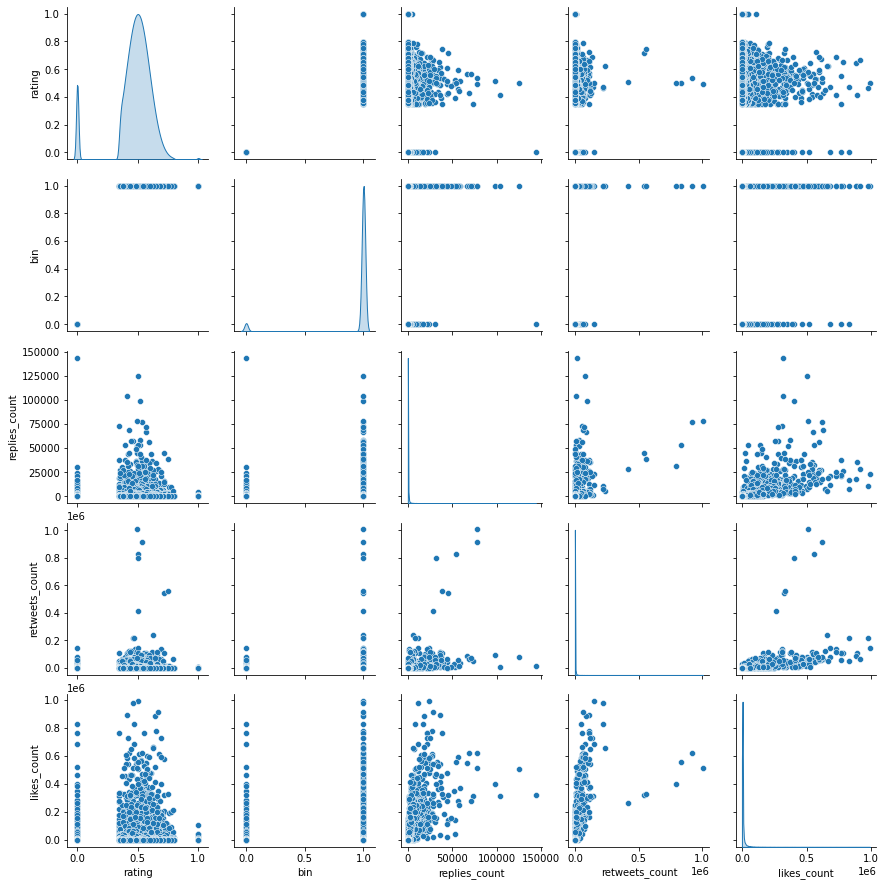

In [8]:
#sns.pairplot(dataset[['replies_count', 'retweets_count', 'likes_count', 'replies_count_boxcox', 'retweets_count_boxcox', 'likes_count_boxcox']], diag_kind='kde')
#sns.pairplot(dataset[['replies_count', 'retweets_count', 'likes_count', 'bin']], diag_kind='kde')
#sns.pairplot(dataset[['rating', 'bin', 'photos', 'replies_count', 'retweets_count', 'likes_count']], diag_kind='kde')
sns.pairplot(dataset[['rating', 'bin', 'replies_count', 'retweets_count', 'likes_count']], diag_kind='kde')

In [9]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bin,695134.0,0.947432,0.223170,0.0,1.000000,1.000000,1.000000,1.0
rating,695134.0,0.484213,0.142010,0.0,0.435152,0.500031,0.564847,1.0
replies_count,695134.0,25.507525,578.545863,0.0,0.000000,1.000000,4.000000,144229.0
retweets_count,695134.0,102.057928,2719.749790,0.0,0.000000,3.000000,17.000000,1005215.0
likes_count,695134.0,750.386567,9221.529353,0.0,2.000000,17.000000,117.000000,988051.0


# Prepare the data for training

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
#val_dataset = tweets.drop(train_dataset.index)
test_dataset = dataset.drop(train_dataset.index)
val_dataset = test_dataset.sample(frac=0.5, random_state=0)
test_dataset = test_dataset.drop(val_dataset.index)

## Calculate a bias in order to initialize the model's output weights later on

In [11]:
neg, pos, = np.bincount(dataset['bin'])
total = neg + pos

# Fiat bias: 0.53100804
# Erdayastronaut bias: 2.89037479

# Used later on to initialize the model's output weights
initial_bias = np.log([pos/neg])

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
print('Initial bias: {}'.format(initial_bias))

Examples:
    Total: 695134
    Positive: 658592 (94.74% of total)

Initial bias: [2.89164194]


## Calculate class weights in order to balance both classes

In [12]:
# Used later on
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 9.51
Weight for class 1: 0.53


## Gain further insights in the data and process it (stem, remove stop words, ...)

In [ ]:
nltk.download('stopwords')

In [6]:
def process_tweet(tweet, lang='en'):
    """
    Removes stopwords from a tweet and tokenizes it.
    """
    # Tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    if lang == 'de':
        stopwords_ = stopwords.words('german')
        stopwords_file = open("stop_words_german.txt", "r")
        sws = stopwords_file.read().split("\n")
        stopwords_file.close()
        stopwords_ += sws
        no_stopwords = ['mann', 'mensch', 'menschen', 'recht', 'rechte', 'rechten', 'rechter', 'rechtes']
        additional_stopwords = ['mal', 'halt', 'sagen', 'schon', 'lassen', 'danke', 'bitte', 'einfach', 'eigentlich', 'schon', 'sich']
        stopwords_ += additional_stopwords
        stopwords_ = [x for x in stopwords_ if x not in no_stopwords]
    elif lang == 'en':
        stopwords_ = stopwords.words('english')
    else:
        print("Language not supported yet, please add it to this function...")
        return
    
    stemmer = Cistem()
    
    tweetsClean = []
    tokenizedTweet = tokenizer.tokenize(tweet)
    for word in tokenizedTweet:
        if (word not in stopwords_):
            stem = stemmer.stem(word)
            tweetsClean.append(stem)
    
    return ' '.join(tweetsClean)

def calc_freqs(tweets, rawTweets=True):
    """
    Calculates word frequencies.
    
    Input:
        tweets: A list of tweets
    Output:
        freqs: A dictionary mapping each word to its frequency
    """
    freqs = {}
    for tweet in tweets:
        if(rawTweets):
            for word in tweet.split():
                if word in freqs:
                    freqs[word] += 1
                else:
                    freqs[word] = 1
        else:
            for word in process_tweet(tweet).split():
                if word in freqs:
                    freqs[word] += 1
                else:
                    freqs[word] = 1
    
    return freqs

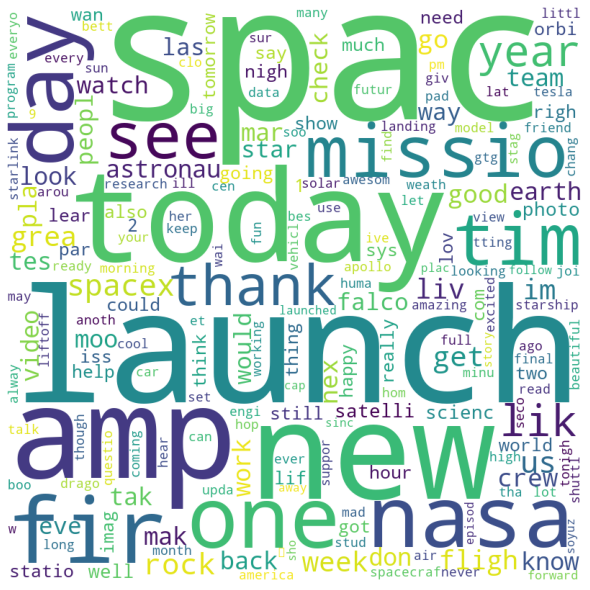

In [31]:
tweets_text = dataset['tweet'].tolist()
freqs = calc_freqs(tweets_text, rawTweets=False)
#pprint(freqs)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(freqs)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Save the resulting dataset

In [7]:
# Separate label and features
train_features = train_dataset.copy()
test_features = test_dataset.copy()
val_features = val_dataset.copy()

dataset['tweet'] = dataset['tweet'].apply(process_tweet)
train_features['tweet'] = train_features['tweet'].apply(process_tweet)
test_features['tweet'] = test_features['tweet'].apply(process_tweet)
val_features['tweet'] = val_features['tweet'].apply(process_tweet)

# TODO: Add Hashtags and Cashtags to the features
train_features.drop(columns=['photos', 'replies_count', 'retweets_count', 'likes_count', 'video', 'hashtags', 'cashtags'], inplace=True)
test_features.drop(columns=['photos', 'replies_count', 'retweets_count', 'likes_count', 'video', 'hashtags', 'cashtags'], inplace=True)
val_features.drop(columns=['photos', 'replies_count', 'retweets_count', 'likes_count', 'video', 'hashtags', 'cashtags'], inplace=True)

# Remove empty tweets
dataset = dataset.dropna(subset=['tweet'])
train_features = train_features.dropna(subset=['tweet'])
test_features = test_features.dropna(subset=['tweet'])
val_features = val_features.dropna(subset=['tweet'])

# Store those in a new file
dataset.to_csv('{}/preproc/dataset.csv'.format(miner.handle), encoding='utf-8', line_terminator='\r\n', index=False)
train_features.to_csv('{}/preproc/train.csv'.format(miner.handle), encoding='utf-8', line_terminator='\r\n', index=False)
test_features.to_csv('{}/preproc/test.csv'.format(miner.handle), encoding='utf-8', line_terminator='\r\n', index=False)
val_features.to_csv('{}/preproc/val.csv'.format(miner.handle), encoding='utf-8', line_terminator='\r\n', index=False)

# Store each class in another new file since we'll need those for training the regressor
train_features_0 = train_features[train_features.bin == 0]
train_features_1 = train_features[train_features.bin == 1]
train_features_0.to_csv('{}/preproc/train_only_0.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)
train_features_1.to_csv('{}/preproc/train_only_1.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)
test_features_0 = test_features[test_features.bin == 0]
test_features_1 = test_features[test_features.bin == 1]
test_features_0.to_csv('{}/preproc/test_only_0.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)
test_features_1.to_csv('{}/preproc/test_only_1.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)
val_features_0 = val_features[val_features.bin == 0]
val_features_1 = val_features[val_features.bin == 1]
val_features_0.to_csv('{}/preproc/val_only_0.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)
val_features_1.to_csv('{}/preproc/val_only_1.csv'.format(handle), encoding='utf-8', line_terminator='\r\n', index=False)

#train_labels = train_features.pop('bin')
#test_labels = test_features.pop('bin')
#val_labels = val_features.pop('bin')